# Mutli-class sentiment analysis with neural nets

In [1]:
### Imports ###

import numpy as np
import pandas as pd
import math
from tqdm import tqdm
import os
import sys
import itertools
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS

import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models.phrases import Phraser, Phrases
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Loading the data

The dataset is composed of 12,000 amazon reviews of books accompanied by by a numerical rating. These range from 1 to 5 where 5 is very positive and 1 is very negative. The text reviews will be the inputs and the numerical figure will be the outputs meaning there will be 5 sentiment classes. The goal of the model will be to map text to the correct sentiment or numerical value.


In [2]:
# Pathway to the dataset
df = pd.read_csv('/Users/isaaclambert/Desktop/amazon_sentiment/preprocessed_kindle_review .csv')

In [3]:
# The 12,000 reviews can be seen in the first dim
df.shape

(12000, 4)

# Examples from each of the 5 classes
* the code prints the first review in the df for each of the classes

In [4]:
# Class 1 - very negative 
print(df.reviewText[df['rating'] == 1].iloc[0])

When I read the description for this book, I couldn't wait to read it. Once I downloaded it to my Kindle, I found it extremely hard to keep reading it.  To be honest, I stopped reading halfway through the book. It began slow and remained a slow, uninteresting read.  It lacked passion; not making love passion, but passion for life. Neither Jada or Aaron were interesting characters and the story was too, too `everything is perfect'.  Everybody is just so understanding and accommodating--the bit of drama with his father and her grandmother was blah.  To give an example of what I mean (and there are MANY), Aaron finally finds out almost  half way into the book that he fathered a child 5 years ago--keep in mind that Aaron and Jada kept in contact for a few months after he left and she never mentioned to him that she was pregnant. When she finally tells him he has a son, Aaron becomes overwhelmed with emotions (misty eyed) knowing that he's a father. WTH!  I think most men would be upset/ang

In [5]:
# Class 2 - negative
print(df.reviewText[df['rating'] == 2].iloc[0])

This is not a good ghost story, nor is it a romance. To me it was a poorly written Harlequin romance with a lot of smut thrown in.  The author doesn't appear to know what genre` she's trying to capture.There were numerous typos which I found annoying. The author also incorporated Elvis' name, but did it in a way that I found disrespectful as well as inaccurate. Stephen King she's NOT!If you're looking for a good ghost story, this isn't it. If you're looking for a romance novel, this isn't that either.It had the potential to be an interesting story, but instead turned out to be a mish-mash of ideas.I won't be looking for any other books from this author.


In [6]:
# Class 3 - neutral 
print(df.reviewText[df['rating'] == 3].iloc[0])

I bought this book because I loved the cover and I try to read any Civil War romance I come across. Unfortunately, I wanted more story. If the book was longer to compensate for all the bedroom activity it would be a much better read. Both the Confederate Colonel and the Southern widow were good characters and relatable, but were only written at a surface level because not enough time was given to development. At least the readers were given memories from their past to help fill in some of the blanks. And the epilogue detracted from the story in my opinion.I like Debra Glass, but this wasn't my favorite read.


In [7]:
# Class 4 - positive 
print(df.reviewText[df['rating'] == 4].iloc[0])

I really enjoyed how this story developed.  Its a well-written Sci-fi depicting what happens when an alien race quietly tries to study earth and one of the members of the scientific team gets away from the group and is discovered by a human.  The world-building of the alien race was easy to follow since explanations came steadily throughout the story instead of one long monologue at the beginning.The characters' personalities and situations were established for some time before they actually come in contact with each other and then their relationship developed at a believable rate as they first had the culture/language barrier and then that period of just exploring their differences and similarities before it grew into something of a romantic nature.Not to say physical attraction wasn't there pretty soon after they met though Kent is a bear about it because he's recently sworn off women and here at his campsite remote from civilization he is joined by a female.Kent is a biology profess

In [8]:
# Class 5 - very positive 
print(df.reviewText[df['rating'] == 5].iloc[0])

This book was the very first bookmobile book I bought when I was in the school book club. I loved the story then and I bet a dollar to a donut I will love it again. If my memory serves, I bought this book in 5th grade. That would have been about 1961. I am looking forward to reliving the memories.


# Cleaning the dataframe and analysing the data

In [9]:
# Rename Column 'reviewText' to reviews
df_renamed = df.rename(columns={"reviewText": "Reviews", "rating": "Label"})

# Delete unnecessary colums 
df_no_columns = df_renamed.drop(columns=['summary', 'Unnamed: 0'])

In [10]:
df_no_columns

,Label,Reviews
0,5,This book was the very first bookmobile book I...
1,1,"When I read the description for this book, I c..."
2,5,I just had to edit this review. This book is a...
3,5,I don't normally buy 'mystery' novels because ...
4,5,"This isn't the kind of book I normally read, a..."
...,...,...
11995,2,Had to read certain passages twice--typos. Wi...
11996,3,Not what i expected. yet a very interesting bo...
11997,5,Dragon Knights is a world where Knights ride d...
11998,4,"Since this story is very short, it's hard to s..."


## Frequency distribution of labels

In [11]:
# Get label distrubution info
lab_counts = []
spread = range(1, 6)
for i in spread:
    lab_counts.append(len(df_no_columns[(df_no_columns['Label'] == i)]))

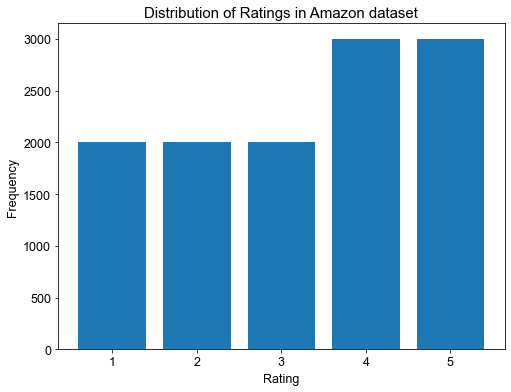

In [12]:
# Make Plot
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12.5})

plt.bar(spread, lab_counts)
fig = plt.gcf()

plt.title('Distribution of Ratings in Amazon dataset')
plt.ylabel("Frequency")
plt.xlabel("Rating")

fig.set_size_inches(8,6)


* While there are more examples for class 4 and 5 there is still a decent frequency baseline for classes 1, 2 and 3 and the frequency gap is not huge. This should mean that accuracy is not artificially skewed towards classes 4 and 5.

## Frequency distribution of sentance length

In [13]:
# Make list of sentances
raw_reviews_lst = list(df_no_columns.Reviews)

# Split into token
token_raw_reviews_lst = [word_tokenize(i) for i in raw_reviews_lst]

In [14]:
# Make list of lengths of sentances 
sen_len = [len(i) for i in token_raw_reviews_lst]

# Sort list 
sort_sen_len = sorted(sen_len)

# Get counts of differnt lengths of sentance as dict
counts_sen_length = Counter(sort_sen_len)

# Take keys - sentance lengths
x_sen_length = list(counts_sen_length.keys())

# Take values - counts
y_sen_l_counts = list(counts_sen_length.values())

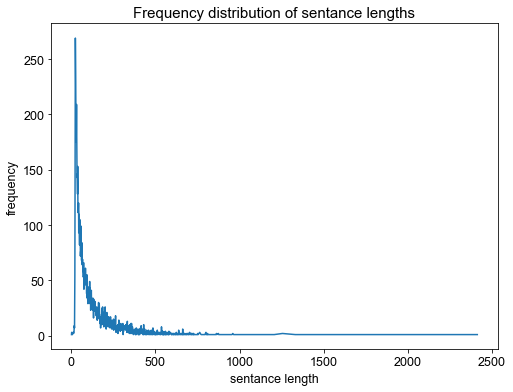

In [15]:
# Make Plot
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12.5})

plt.plot(x_sen_length, y_sen_l_counts)
fig = plt.gcf()

plt.title('Frequency distribution of sentance lengths')
plt.ylabel("frequency")
plt.xlabel("sentance length")

fig.set_size_inches(8,6)


* Since past length 500 the counts are very low and plateau, I will re-plot the graph to around length 400 in order to better visualise the curve.

In [16]:
x_sen_length[400]

406

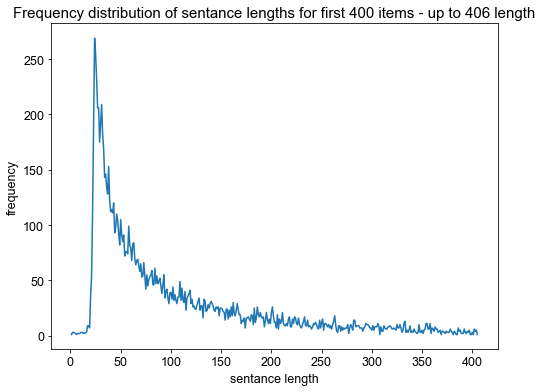

In [17]:
# Make Plot
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12.5})

plt.plot(x_sen_length[:400] , y_sen_l_counts[:400])
fig = plt.gcf()

plt.title('Frequency distribution of sentance lengths for first 400 items - up to 406 length')
plt.ylabel("frequency")
plt.xlabel("sentance length")

fig.set_size_inches(8,6)


In [18]:
print(f'Mean length of sentance by tokens: {float("{:.3f}".format(sum(sen_len) / 12000))}')
print(f'Medium length of sentance by tokens: {sort_sen_len[6001]}')

Mean length of sentance by tokens: 124.95
Medium length of sentance by tokens: 70


* The medium is 70 but the mean is 124.95. This suggests that some sentences are extremely long skewing the data to the right. Likewise from the graph it is clear that the most common sentence length is slightly below 50. 
* In terms of padding, so that not too much data is lost but equally so that not too many sentences are truncated, this all suggests that a starting range of between 50 and 150 sequence/token length should be explored.

# Text Normalization / Preprocessing 
Text normalisation should occur before word embeddings are generated. This means similarity between tokens can be maximised and minimised where it should be providing the best embeddings. For example if dog and Dog were treated as two separate tokens, the occurrences of target word canine in context dog would be lower erroneously reducing similarly and creating skewed embeddings.
The steps are:
* Cleaning the dataframe and checking the data type 
* Making tokens all lower case and removing numbers 
* Tokenising the sentences and removing punctuation
* Lemmatising the tokens
* Apply phrase detection to create compound tokens
* Padding

In [19]:
def labels_to_int_and_text_to_list(df):
    '''
    ouputs labels df with ints + reviews as a list
    '''
    # Take columns of just the review and labels
    reviews = df['Reviews']
    labels_object = df['Label']

    # Convert reviews column to list
    lst = reviews.tolist()

    # Change labels dtype from obj to int
    lab2 = labels_object.astype({'Label':'int'})
    
    return lst, lab2


In [20]:
# Call function labels_to_int_and_text_to_list
reviews_lst, labels = labels_to_int_and_text_to_list(df_no_columns)

In [21]:
def object_type_finder(lst):
    '''
    Function to determine object types in list 
    '''
    types = [type(i) for i in lst]
    return set(types)

In [22]:
print(object_type_finder(reviews_lst)) 

# Object classes are all strings so dtype conversion is unnecessary

{<class 'str'>}


In [23]:
def lower_and_nonums(lst):
    '''
    Takes lists of reviews and makes them all lower case + removes numbers
    '''
    
    # Makes new list with lowercase strings
    lower_str = [i.lower() for i in lst]
    
    # Make new list without numbers
    nums = r'[0-9]'
    low_nonum = [re.sub(nums, '', i) for i in lower_str]
    
    return low_nonum

In [24]:
# Call function lower_and_nonums
tt_low_nonum = lower_and_nonums(reviews_lst)

In [25]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/isaaclambert/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [26]:
def nest_tokenize_no_punct(lst):
    '''
    outputs a nested list with sentances outer and tokens inner + removes punctuation
    '''
    
    # Form nested list with reviews split into tokens
    token_nested_lst = [word_tokenize(i) for i in lst]
    
    # Remove punctuation tokens
    no_p_n = [[ii for ii in i if ii.isalpha()] for i in token_nested_lst]
    
    return no_p_n

In [27]:
# Call function nest_tokenize_no_punct
no_punct_nested = nest_tokenize_no_punct(tt_low_nonum)

In [28]:
# Download for lemmatizatoin
nltk.download('wordnet')

def stem_or_lem(nested_lst, norm):
    '''
    For Stemming data norm == 'stem' | for lemmatizing data norm == 'lem'
    '''
    if norm == 'stem':
        ps = PorterStemmer()
        ste = [[ps.stem(ii) for ii in i] for i in nested_lst]
        return ste
    
    elif norm == 'lem':
        lemmatizer = WordNetLemmatizer()
        lemmat = [[lemmatizer.lemmatize(ii) for ii in i] for i in nested_lst]
        return lemmat

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/isaaclambert/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [29]:
# Call stem_or_lem for Lemitization
lemmatized = stem_or_lem(no_punct_nested, 'lem')

## Phrase detection
* English_connector_words provides a vocabulary of commonly co-occuring english words which can be treated as one token by combining them with an underscore.
* This reduces feature count lowering computational cost.
* It can also help with accuracy since multi-word terms like New York which refer to one object are treated as one token.

In [30]:
# Create the phrases from the list lemmatized
phrases = Phrases(lemmatized, min_count=35, threshold=40, connector_words=ENGLISH_CONNECTOR_WORDS)

# The Phraser object is used to transform sentences
n_gram = Phraser(phrases)

# Apply  Phraser to transform sentances
lemmatized = list(n_gram[lemmatized])


### Phrases paramater tuning
* Phrases parameters such as min_count and threshold must be tuned to ensure the algorithm is not overly greedy and too many tokens are combined which would reduce accuracy. 

In [31]:
def token_extractor(lst):
    '''
    takes a nested list and output tokens as flat list

    '''
    empty_lst = []
    for i in lst:
        for ii in i:
            empty_lst.append(ii)
            
    return empty_lst


In [32]:
# Token extractor is called to produce a flat list of the tokens including compound tokens
lem_tok = token_extractor(lemmatized)

In [33]:
# The count of compound tokens is recorder and a list of compound tokens is made
com_count = 0
compounds = []
for i in lem_tok:
    if '_' in i:
        com_count += 1
        compounds.append(i) 

In [34]:
print(f'Count of compound tokens: {com_count}')
print(f'Count of unique compound tokens: {len(set(compounds))}')

Count of compound tokens: 9129
Count of unique compound tokens: 72


In [35]:
# These are the unique compound tokens, they may be checked by removing the #

#set(compounds)

In the above two cells the number of compound tokens and unique compound tokens are checked. Likewise a list of the unique compound tokens can be printed. This is to ensure the phrases algorithm is not being overly greedy. I reran the code adjusting the parameters until results I was happy with were produced. This equated to a min_count of 35 and threshold value of 40.

## Dataframe and Word Cloud visulizations

In [36]:
def nested_lst_to_df(nested_lst, label):
    '''
    takes nested token list and outputs df with sentance segmetns and lables
    '''
    flat_lst = [' '.join(i) for i in nested_lst]
    df = pd.DataFrame(flat_lst, columns = ['Reviews'])
    df = pd.concat([df, label], axis=1)
    return df 

In [37]:
# Call nested_lst_to_df function to make complete lematized df
df_lemma = nested_lst_to_df(lemmatized, labels)

In [38]:
# This is the dataframe for the preprocessed data

df_lemma.head()

,Reviews,Label
0,this book wa the very first bookmobile book i ...,5
1,when i read the description for this book i co...,1
2,i just had to edit this review this book is an...,5
3,i do normally buy novel because i just do like...,5
4,this is the kind of book i normally read altho...,5


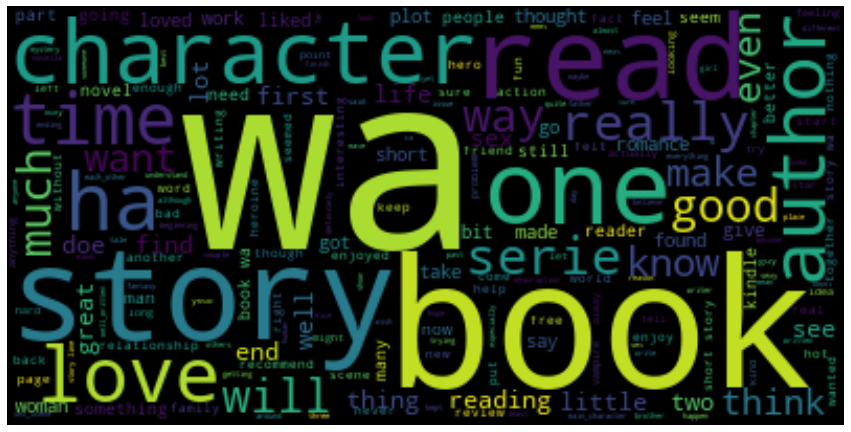

In [39]:
# Word Cloud plot

#Pure text
text = " ".join(i for i in df_lemma.Reviews)

# Stopword removal 
stopwords = set(STOPWORDS)

# Define and plot word cloud
wordcloud = WordCloud(stopwords=stopwords, background_color="black").generate(text)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

* With the exception of a vocabulary of common and uninteresting 'stop words' the most common words in the language corpus correlated to size can be seen above. Since lematization has been applied words are reduced to their lemma (core meaning) hence 'wa' for 'was'.

# Word Emeddings and Word2Vec

Word2Vec's SkipGram creates sparse vectors to be used as the input to the Neural Net classifiers. The algorithm works by treating target word t in context c and positive examples and randomly sampling the language corpus for contexts where t does not occur, that is negative examples. Two embeddings are thus created for each token, one with the token as the target word and one with the token as a context vector. The embeddings are the logistic regression weights. The features are initially represented by random values for the weights. These weights are then tweaked to optimise the loss function. The loss function is a measure of similarity and dissimilarity between words. It is maximised in positive examples and minimised in negatives. The final regression weights are the word embeddings which will be used as neural net inputs.

In [40]:
# Import and train the Word2Vec algorithm on the lemmatized corpus
    # Minimum word count = 3
    # Context window = 5

# Default dims = 100
w2v_model = Word2Vec(lemmatized, min_count=1, workers=2, window=5 )

In [41]:
# Vocabulary size
print(f'Vocabulary size: {len(w2v_model.wv)}')

Vocabulary size: 25957


In [42]:
w2v_model.wv.most_similar("good") 

[('great', 0.8240376114845276),
 ('nice', 0.794924795627594),
 ('decent', 0.7230861783027649),
 ('bad', 0.7027564644813538),
 ('okay', 0.690157413482666),
 ('well_written', 0.6760596632957458),
 ('short', 0.6758881211280823),
 ('quick', 0.6632158756256104),
 ('fine', 0.6626590490341187),
 ('cute', 0.646676242351532)]

The words most similar to 'good' are output above. Most of them somewhat synonymous meaning weights indicating high similarity is scores are promising. The presence, however, of the antonym 'bad' as 4th most similar is interesting. It is not necessary problematic or surprising since good and bad may be used in many of the same contexts. In certain dimensions, these words may still be far apart. In order to test the similarity/dissimilarity between positives and pejoratives I will apply dimensionality reduction then a data visualisation.

## Dimensionality Reduction and Visualisation

* Dimensionality reduction algorithms such as the PCA take data points in N-dimensional hyperspace and project them onto lower dimensions while still trying to maintain patterns and relationships. Here this is done onto a plain in order to facilitate a 2D visualisation of the word embeddings.

In [43]:
# Make a list of the unique tokens in the vocabulary 
unique_tokens = list(set(lem_tok))

# Take a sample of the first 1000 unique tokens to reduce computation cost
sample_un_tok = unique_tokens[:1000]

# Make an array of the 100D embeddings for the 1000 unique token sample
sample_embeddings = w2v_model.wv[sample_un_tok]

In [44]:
# Import the PCA model setting target to 2 dims
pca = PCA(n_components=2)

# Fit the model 100D sample embeddings for reduction 
pca.fit(sample_embeddings)

PCA(n_components=2)

In [45]:
# Define the words which will be tested
test_words = ['good', 'wonderful' , 'fun', 'awesome', 'amazing','bad', 'dull', 'dreadful', 'poor', 'worse']


In [46]:
# Collect the 100D embeddings for the words which will be tested 
test_embeddings = w2v_model.wv[test_words]

# Apply PCA tranformation to the test embeddings to reduce them to 2 dims
redu_test_embeddings = pca.transform(test_embeddings)

In [47]:
# Take the x values from the 2D embeddings 
x_slice = redu_test_embeddings[: , :-1]

# Flatten
x_slice = x_slice.squeeze()

In [48]:
# Take the y values from the 2D embeddings
y_slice = redu_test_embeddings[: , 1:]

# Flatten
y_slice = y_slice.squeeze()

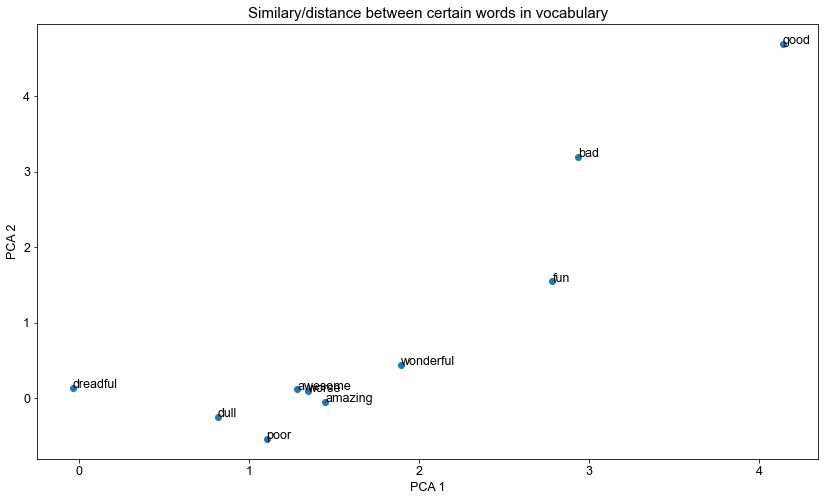

In [49]:
# Make Plot 

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12.5})
plt.scatter(x_slice, y_slice)
plt.title('Similary/distance between certain words in vocabulary')
plt.ylabel("PCA 2")
plt.xlabel("PCA 1")
fig = plt.gcf()
fig.set_size_inches(14, 8)
for i, ii in enumerate(test_words):
    plt.annotate(ii, (x_slice[i], y_slice[i]))
plt.show()

With sentiment analysis in mind there should be a large distance between overly negative and positive words. With the above set of words, this is not the case, they do not obviously fit into two separate clusters. This is not entirely surprising since the language corpus used to generate the embeddings was fairly small and the PCA was trained on a subset of 1000 tokens. Nonetheless, using these embeddings as the input for a neural net could lower accuracy on novel data and risk overfitting on the training data. As such, a larger dataset is required to produce the embeddings. As such, I will proceed by importing pre-trained embeddings. 

# Splitting the data

In [50]:
# Split 80% train to 20% test
train_size = 0.8

# Define limit for padding
max_length = 150

In [51]:
# Split the data psudeo-randomly 
# Shuffled = True
train_data, test_data = train_test_split(df_lemma, test_size=1-train_size, random_state=21) 

print(f'Train size: {len(train_data)} reviews')
print(f'Test size: {len(test_data)} reviews')

Train size: 9600 reviews
Test size: 2400 reviews


In [52]:
# Import tokenizer
tokenizer = Tokenizer()

# Apply to text in training set 
tokenizer.fit_on_texts(train_data.Reviews)

# Word indexes
word_index = tokenizer.word_index

# Token count
vocab_size = len(tokenizer.word_index) + 1

print(f'Vocabulary Size: {vocab_size}')

Vocabulary Size: 23572


In [53]:
#word_index

# Padding
The inputs for the later neural network model will be the embeddings for each word of the sentences/reviews. The problem is that the reviews differ in length meaning that the sequence length, thus the input sizes, would vary. Padding resolves this issue by creating a uniform sequence length. Shorter sentences are 'padded' with additional 0s while longer sentences are truncated meaning data points exceeding the uniform length will be dropped. Padding is important in helping Neural Nets run smoothly, some actively require padding while in some cases, it is not necessary but helps computational efficiency. 
* A sequence length of 150 (the upper limit of the range specified above) is defined above with the variable 'max_length'.
* As seen in the terminal of the cell below the sequence length of all the reviews is now 150.

In [54]:
# Padding train dataset
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.Reviews), maxlen = max_length)

# Padding test dataset
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.Reviews), maxlen = max_length)

print(f'X training dimensions: {x_train.shape}')
print(f'X testing dimensions: {x_test.shape}')

X training dimensions: (9600, 150)
X testing dimensions: (2400, 150)


# Encoding the Labels

* Using LabelBinarizer the labels will be encoded as one hot vectors.

In [55]:
# Import one-hot-encoding model 
lb = LabelBinarizer()

# Fit and transform train labels 
trainY = lb.fit_transform(train_data.Label.to_list())

# Transform test labels 
testY = lb.transform(test_data.Label.to_list())

In [56]:
print(f'y_train dimensions: {trainY.shape}')
print(f'y_test dimensions: {testY.shape}')

y_train dimensions: (9600, 5)
y_test dimensions: (2400, 5)


# Pre-trained Word Embeddings

Transfer learning will be leveraged to access better word embeddings. Pre-trained embeddings are trained on massive language corpuses improving the results. It is important to note the type of language corpus used to generate the embeddings as factual corpuses like wikipedia will perform less well on sentiment based tasks. Here [Glove Embedding from Stanford AI](https://nlp.stanford.edu/projects/glove/) is downloaded.

In [57]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip

--2022-12-26 18:15:43--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-12-26 18:15:44--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-12-26 18:15:44--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.15’

g

In [58]:
# Path for emeddings
glove_emb = '/Users/isaaclambert/glove.6B.300d.txt'

# Set certain parameters for the model
em_dim = 300
LR = 0.00045
batch_size = 128
epochs = 5

# Define model pathway
model_path = '.../Users/isaaclambert/working/best_model.hdf5'

* The embedding dimensions 'em_dim' are set to 300 as apposed to the standard 100 used by Word2Vec for greater accuracy
* the Learning rate (LR), nuber of epochs (epochs) and batch size (batch_size) are also all defined above.

In [59]:
# Empty dictionary 
embeddings_index = {}

# Open embeddings
f = open(glove_emb)

# Create dictionary of tokens and 300d embeddings 
for i in f:
    values = i.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()

In [60]:
print(f'Count of word vectors in Stanford AI dataset:  {len(embeddings_index)}')

Count of word vectors in Stanford AI dataset:  400000


* The Stanford AI data set has a vocabulary of 400,000 as opposed to the Amazon book review dataset vocabulary size of 26,076. 
* This indicates that the Stanford AI dataset is a much larger language corpus likely to produce better embeddings. 
* It will also help will with generalising on novel data where words don't appear in the amazon dataset but do within the Stanford dataset. 

# Re-visualizing the data

In [61]:
# Again take a sample of 1000 datapoints from the Stanford embeddings
sample_stan_em = list(embeddings_index.values())[:1000]

In [62]:
# Import new PCA model
pca2 = PCA(n_components=2)

# Fit the model to the new sample 
pca2.fit(sample_stan_em)

PCA(n_components=2)

In [63]:
# Take new 300D embeddings for test words 
new_test_embeddings = [embeddings_index[i] for i in test_words]

# Tranford the test word embeddings from 300 to 2 dims
new_redu_test_embeddings = pca2.transform(new_test_embeddings)

In [64]:
# Take the x values from the new 2D embeddings 
new_x_slice = new_redu_test_embeddings[: , :-1]

# Flatten
new_x_slice = new_x_slice.squeeze()

In [65]:
# Take the y values from the new 2D embeddings
new_y_slice = new_redu_test_embeddings[: , 1:]

# Flatten
new_y_slice = new_y_slice.squeeze()

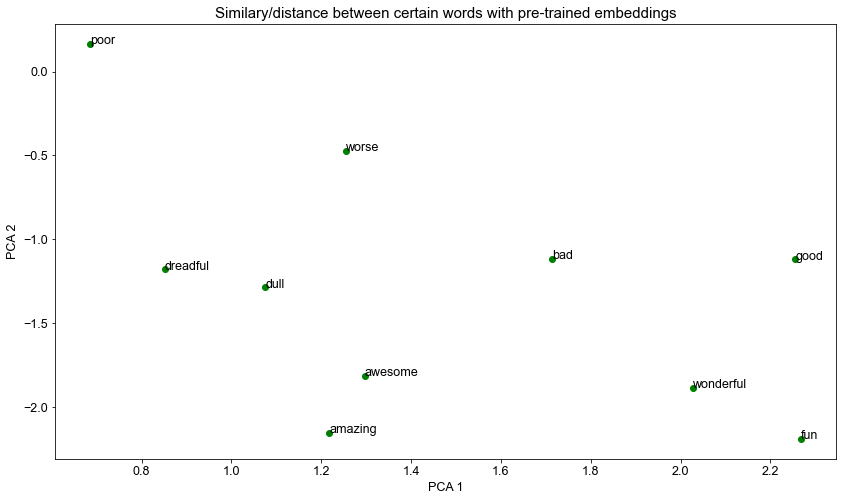

In [66]:
# Make New Plot 

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12.5})
plt.scatter(new_x_slice, new_y_slice, color='g')
plt.title('Similary/distance between certain words with pre-trained embeddings')
plt.ylabel("PCA 2")
plt.xlabel("PCA 1")
fig = plt.gcf()
fig.set_size_inches(14, 8)
for i, ii in enumerate(test_words):
    plt.annotate(ii, (new_x_slice[i], new_y_slice[i]))
plt.show()

* The same process of dimensionality reduction is applied to the new embeddings.
* These embeddings so seem to be better since in 2 dimensions, it is easier to visually separate positive and negative token.
* Positive tokens tend towards the bottom right corner while negative tokens tend towards the top left.
* The token 'bad' is still somewhat anomalous yet this can be accounted for due to its potential to occur in windows with positive target words as a comparative term.

# Embedding Matrix and Layer

* This will be the first layer of the model.
* It will select the embeddings for each token within each input sentance.

In [67]:
# Form embedding matrix with tokens from amazon data set and embeddings from Standford AI

embedding_matrix = np.zeros((vocab_size, em_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [68]:
# Form embedding layer 
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          em_dim,
                                          weights=[embedding_matrix],
                                          input_length=max_length,
                                          trainable=False)

# Neural Network

In their simplest form NNs are layers of neural units (NU). There is an input layer, one or more hidden layers and an output layer with as many NUs as there are classes. Neural units take the weighted sum of the inputs and apply non-linear functions such as relu and tanh. The weights are calculated with a loss function  such as cross-entropy-loss and SDG is used to calculate the gradients. Error back propagation computes the loss in regards to each element and updates it accordingly. A more sophisticated form of NN is a recurrent NN (RNN). In RNNs there are time steps where each element of the input data is computed one by one. Two inputs are used, the input from the current time step and the activations from the hidden layer at the previous time step. This is useful for sequential data like text since the inputs from the previous time steps connect the data, adding context to the current input. Here I will used a variant of an RNN called an LSTM since it performs better with longer sequences of data such as my 150 length padded sentences. LSTMs contain three types of gates which help regulate the data. There are forget gates which deleted information which is redundant looking forward; input/add gates which keep and regulate information for later use; and output gates which allow information to pass into the current hidden state.  These functions are performed by a hidden unit which is called the LSTM. This unit contains a ‘context vector’ or ‘cell state’.  My LSTM is bi-directions meaning information can pass both ways. This is useful and it means that a word can be connected to or contextualised by words preceding and following it. I will also add a convolution layer. This is a filter which performs a convolutions operation. Such filter detect certain features within the data. They also compresses the model by using max pooling, reducing the number of connections and allowing weights to be shared along the edges of the model.


In [69]:
# Define neural network architecture and parameters

sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

x = SpatialDropout1D(0.1)(embedding_sequences)
x = Conv1D(64, 10, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1))(x)
x = Dense(512, activation='tanh')(x)
x = Dropout(0.1)(x)
x = Dense(64, activation='relu')(x)

outputs = Dense(5, activation='softmax')(x) 

model = tf.keras.Model(sequence_input, outputs)

The model’s hyper-parameters (HP) were tuned iteratively with a parameter sweep. This involved changing one HP and retraining the model, then recoding the effect on accuracy and validation loss. The HPs which tuned were:
* Learning rate
* Sentence padding length
* Batch size 
* Number of embedding dimensions 
* Number of epochs 
* Types of activation function used
* Number of layers and size of the layer ie how many NUs each layer contained 
* The drop out which is a regulariser preventing overfitting 


In [70]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 300)          7071600   
                                                                 
 spatial_dropout1d (SpatialD  (None, 150, 300)         0         
 ropout1D)                                                       
                                                                 
 conv1d (Conv1D)             (None, 141, 64)           192064    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense (Dense)               (None, 512)               66048 

In [71]:
# Add optimizer with multi-class loss function 
model.compile(optimizer=Adam(learning_rate=LR), loss='categorical_crossentropy', metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = LR, monitor = 'val_loss', verbose = 1)

In [72]:
# Train model 
history = model.fit(x_train, trainY, batch_size=batch_size, epochs=epochs,
                  validation_data=(x_test, testY), callbacks=[ReduceLROnPlateau])

Epoch 1/5
75/75 [==============================] - 50s 603ms/step - loss: 1.4700 - accuracy: 0.3224 - val_loss: 1.3745 - val_accuracy: 0.3783 - lr: 4.5000e-04
Epoch 2/5
75/75 [==============================] - 45s 595ms/step - loss: 1.3276 - accuracy: 0.4045 - val_loss: 1.3049 - val_accuracy: 0.4258 - lr: 4.5000e-04
Epoch 3/5
75/75 [==============================] - 49s 654ms/step - loss: 1.2699 - accuracy: 0.4345 - val_loss: 1.2755 - val_accuracy: 0.4321 - lr: 4.5000e-04
Epoch 4/5
75/75 [==============================] - 52s 693ms/step - loss: 1.1964 - accuracy: 0.4670 - val_loss: 1.2565 - val_accuracy: 0.4387 - lr: 4.5000e-04
Epoch 5/5
75/75 [==============================] - 45s 596ms/step - loss: 1.1385 - accuracy: 0.5065 - val_loss: 1.2465 - val_accuracy: 0.4588 - lr: 4.5000e-04


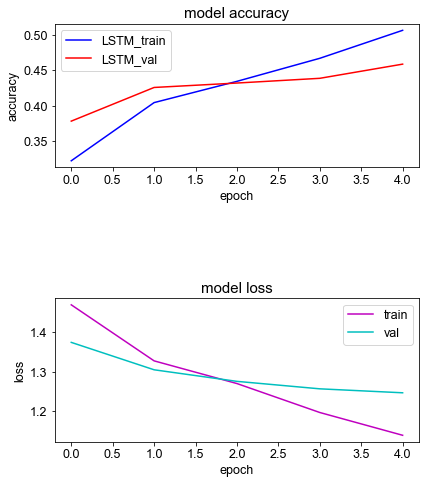

In [73]:
# Plot progression of model accuracy and loss for train and test sets

fig, (te, tr) = plt.subplots(2,1)
te.plot(history.history['accuracy'], c= 'b')
te.plot(history.history['val_accuracy'], c='r')
te.set_title('model accuracy')
te.set_ylabel('accuracy')
te.set_xlabel('epoch')
te.legend(['LSTM_train', 'LSTM_val'])

tr.plot(history.history['loss'], c='m')
tr.plot(history.history['val_loss'], c='c')
tr.set_title('model loss')
tr.set_ylabel('loss')
tr.set_xlabel('epoch')
tr.legend(['train', 'val'])

fig.tight_layout()
fig.set_size_inches(6, 8)
fig.set_size_inches(6, 8)

Training should be stopped when the model reaches the lowest validation loss score as after this point, although training accuracy may continue to increase the model will simply be overfitting the training data and thus will not generalise properly on novel data leaning to a lower accuracy on test, validation or novel data.

# Investigating the results 

In [74]:
# Get label/Y predictions for test set
y_pred = model.predict(x_test)

# Tranform probabilities to one hot-encoding
onehot_y_pred = to_categorical(np.argmax(y_pred, axis=1), 5)

75/75 [==============================] - 6s 64ms/step


In [75]:
# Convert from one-hot encoding to raw ints
raw_testY = testY.argmax(axis=1)+1
raw_onehot_y_pred = onehot_y_pred.argmax(axis=1)+1

In [76]:
# Create np matrix with cm values 
con_mat = confusion_matrix(raw_testY, raw_onehot_y_pred, labels= range(1,6))

In [77]:
# Define column and index names / labels 
ind_col = list(range(1,6))

# Form df with Labels and cm values 
df_con_mat = pd.DataFrame(con_mat, index = [ind_col], columns = [ind_col])

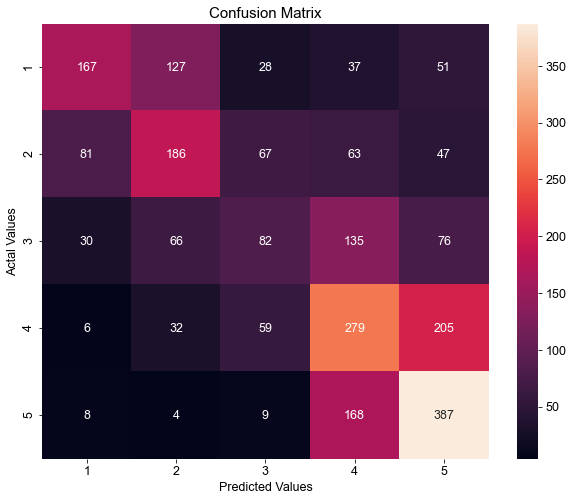

In [78]:
# Plot confusion matrix / Heat Map from df
plt.figure( figsize=(10,8))
sns.heatmap(df_con_mat, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

A confusion matrix is plot to analyse the instances of true positives, false positives and false negatives. The model reaches ~50% accuracy. This is not awful considering the baseline for five classes would be 20%. Indeed, likewise, the class delineations are subtle and even a human may struggle to identify whether whether a piece of text corresponds to sentiment 4 or 5 in positives cases or 1 or 2 in negative cases. This is reflected in the confusion matrix since there are many examples adjacent to the left to right parallel lines. These are instances where the sentiment was misjudged by a single class. For example there is a high frequencies of class 4 predicted as class 5. These find gradations may simply be too difficult a task meaning it must be simplified. The best way to do some would be to combine classes. This will be addressed below.

## Extreme Errors

Before combining the classes, I will to investigate the most extreme errors to check the model is not doing something very wrong. These cases are represented by the bottom left corner and top right corners in the confusion matrix. These represent instances respectively in which sentiment 5 was predicted as 1 and sentiment 1 was predicted as 5.

In [79]:
def review_finder(lab1, lab2):
    '''
    takes two labels and outputs information about instances where label values are met 
    '''
    # Make empty dic 
    dic ={'Index': [] , 'Sentance': [] , 'Actual': [] , 'Predicted': []}
    
    # Find positions where actual and predicted == specified values
    for count, i in enumerate(raw_testY):
        if i == lab1 and raw_onehot_y_pred[count] == lab2:
            
            # Append relevent information at these positions 
            dic['Index'].append(list(test_data.reset_index()['index'])[count])
            dic['Sentance'].append(test_data['Reviews'].to_list()[count])
            dic['Actual']. append(raw_testY[count])
            dic['Predicted'].append(raw_onehot_y_pred[count])
       
    return dic

In [80]:
# Call review_finder 5,1
five_one_dic = review_finder(5, 1)

In [81]:
# Call review_finder 1,5
one_five_dic = review_finder(1, 5)

In [82]:
# Dictionary to df 5,1
five_one = pd.DataFrame.from_dict(five_one_dic)
display(five_one)

,Index,Sentance,Actual,Predicted
0,8852,hooray this is a relatively glitch free digita...,5,1
1,8584,i read this story a year_ago it grab you from ...,5,1
2,2372,i am completely in live with this book the onl...,5,1
3,9913,at about word i not sure that planter punch qu...,5,1
4,6715,i loved this book i loved that character were ...,5,1
5,520,i ca explain why it ha taken so many year to f...,5,1
6,276,i can not say enough good thing about this boo...,5,1
7,1375,i would have preferred a little more back stor...,5,1


In [83]:
display(five_one['Sentance'].loc[2])

'i am completely in live with this book the only drawback would be that the second book wa supposed to to be released year_ago and still nothing'

In [84]:
# Dictionary to df 1,5
one_five = pd.DataFrame.from_dict(one_five_dic)
display(one_five.head(8))

,Index,Sentance,Actual,Predicted
0,10928,if you read the book in the series prior to th...,1,5
1,7029,the one and two star review about sum up my_op...,1,5
2,4449,i enjoy good love story and this one looked pr...,1,5
3,3255,it wa very fast_paced with no depth it made me...,1,5
4,2356,a i wa reading this book i could help but thin...,1,5
5,854,i wish someone would have warned is wonderful ...,1,5
6,355,i had heard a lot about how wonderful this aut...,1,5
7,579,i really didnt like this book it wasnt a fun r...,1,5


In [85]:
display(one_five['Sentance'].loc[0])

'if you read the book in the series prior to this this entire book is a teaser at the end no reason to bother reading it here it wa very good though'

Based on the above examples, it does not seem the model is doing something wrong, rather these extreme errors and the product of bad data. In the 5 predicted 1 example, there is a typo so that love is written as live and the positive sentiment is subsequently lost, furthermore the term drawback is used and still nothing is put which are indicators of negative sentiment. The second example in which 1 was predicted 5 is generally misleading and ambiguous as while class 1 was selected, the customer also wrote ‘it it wa[s] very good though’. There is an argument to be made that data points of this low quality or misleading nature should simply be deleted.

# Altering the Labels / Classes

The best way to reduce the number of classes is to combine 1s and 2s which are both negative into one class and 4s and 5s which are both positive into one class. 3s will be left as neutral. This will create a 3-class output. Thus:
* 1s and 2s will be mapped to 0 : negative
* 3s will be mapped to 1 : neutral 
* 4s and 5s will be mapped to 2 : positive 

In [86]:
# Change the classes in the train and test dfs
c3_train_data = train_data.replace(1, 0).replace(2, 0).replace(3, 1).replace(3, 1).replace(4, 2).replace(5, 2)
c3_test_data = test_data.replace(1, 0).replace(2, 0).replace(3, 1).replace(3, 1).replace(4, 2).replace(5, 2)

In [87]:
# Again, encode labels as one-hot-vectors 

# Import new labelBinarizer
lb2 = LabelBinarizer()

# Fit and transform 3 class train labels 
c3trainY = lb2.fit_transform(c3_train_data.Label.to_list())

# Transform 3 class test labels 
c3testY = lb2.transform(c3_test_data.Label.to_list())

In [88]:
print(f'y_train dimensions: {c3trainY.shape}')
print(f'y_test dimensions: {c3testY.shape}')

y_train dimensions: (9600, 3)
y_test dimensions: (2400, 3)


* As seen above there are now 3 dimensions as opposed to 5.

In [89]:
# Get new label distrubution info
c3train_counts = []
c3test_counts = []
c3spread = range(3)

for i in c3spread:
    c3train_counts.append(len(c3_train_data[(c3_train_data['Label'] == i)]))
for i in c3spread:
    c3test_counts.append(len(c3_test_data[(c3_test_data['Label'] == i)]))

c3total = [i + ii for i, ii in zip(c3train_counts, c3test_counts)]

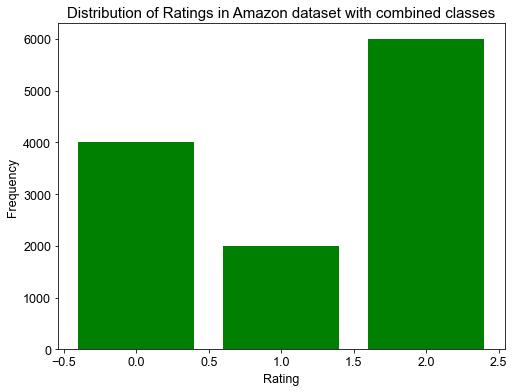

In [90]:
# Make Plot with new classes
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 12.5})

plt.bar(c3spread, c3total, color = 'g')
fig = plt.gcf()

plt.title('Distribution of Ratings in Amazon dataset with combined classes')
plt.ylabel("Frequency")
plt.xlabel("Rating")

fig.set_size_inches(8,6)


# Training a new model with the 3 classes ouput

In [91]:
# Define new number of epochs and learning rate for second model 
    # The learning rate is slowed and more epochs are add
c3epochs = 9
c3LR = 0.00015

In [92]:
# New Neural Net arctitecture and parameters the output layer nodes have been changd

sequence_input2 = Input(shape=(max_length,), dtype='int32')
embedding_sequences2 = embedding_layer(sequence_input2)

x2 = SpatialDropout1D(0.1)(embedding_sequences2)
x2 = Conv1D(64, 10, activation='relu')(x2)
x2 = Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.1))(x2)
x2 = Dense(512, activation='tanh')(x2)
x2 = Dropout(0.1)(x2)
x2 = Dense(64, activation='relu')(x2)

# the output layer nodes have been changd from 5 to 3
c3outputs = Dense(3, activation='softmax')(x2) 

c3model = tf.keras.Model(sequence_input2, c3outputs)

* A new hyper-parameter sweep was conducted, this lead to a new learning rate of 0.00015 and number of epochs of 9.

In [93]:
print(c3model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 300)          7071600   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 150, 300)         0         
 lDropout1D)                                                     
                                                                 
 conv1d_1 (Conv1D)           (None, 141, 64)           192064    
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              66048     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 512)               6604

In [94]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Again add optomizer with multi-class loss function 
c3model.compile(optimizer=Adam(learning_rate=c3LR), loss='categorical_crossentropy', metrics=['accuracy'])
c3ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1, min_lr = 0.00001, monitor = 'val_loss', verbose = 1)

In [95]:
# Train new model
c3history = c3model.fit(x_train, c3trainY, batch_size=batch_size, epochs=c3epochs,
                  validation_data=(x_test, c3testY), callbacks=[c3ReduceLROnPlateau])

Epoch 1/9
75/75 [==============================] - 53s 624ms/step - loss: 0.9745 - accuracy: 0.5342 - val_loss: 0.8848 - val_accuracy: 0.6096 - lr: 1.5000e-04
Epoch 2/9
75/75 [==============================] - 51s 679ms/step - loss: 0.8322 - accuracy: 0.6382 - val_loss: 0.8254 - val_accuracy: 0.6546 - lr: 1.5000e-04
Epoch 3/9
75/75 [==============================] - 49s 656ms/step - loss: 0.7667 - accuracy: 0.6806 - val_loss: 0.7551 - val_accuracy: 0.6979 - lr: 1.5000e-04
Epoch 4/9
75/75 [==============================] - 51s 685ms/step - loss: 0.7318 - accuracy: 0.6971 - val_loss: 0.7390 - val_accuracy: 0.7038 - lr: 1.5000e-04
Epoch 5/9
75/75 [==============================] - 42s 561ms/step - loss: 0.7107 - accuracy: 0.7042 - val_loss: 0.7564 - val_accuracy: 0.6888 - lr: 1.5000e-04
Epoch 6/9
75/75 [==============================] - 49s 654ms/step - loss: 0.6866 - accuracy: 0.7156 - val_loss: 0.7264 - val_accuracy: 0.6988 - lr: 1.5000e-04
Epoch 7/9
75/75 [=============================

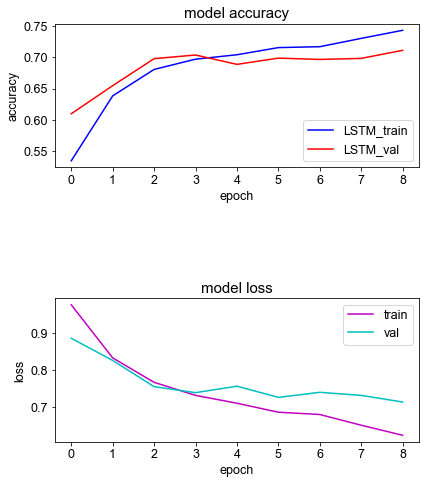

In [96]:
# Plot progression of model accuracy and loss for train and test sets

fig, (c3te, c3tr) = plt.subplots(2,1)
c3te.plot(c3history.history['accuracy'], c= 'b')
c3te.plot(c3history.history['val_accuracy'], c='r')
c3te.set_title('model accuracy')
c3te.set_ylabel('accuracy')
c3te.set_xlabel('epoch')
c3te.legend(['LSTM_train', 'LSTM_val'])

c3tr.plot(c3history.history['loss'], c='m')
c3tr.plot(c3history.history['val_loss'], c='c')
c3tr.set_title('model loss')
c3tr.set_ylabel('loss')
c3tr.set_xlabel('epoch')
c3tr.legend(['train', 'val'])

fig.tight_layout()
fig.set_size_inches(6, 8)

# Analysis of Results

In [97]:
# Get label/Y predictions for test set on new model
c3y_pred = c3model.predict(x_test)

# Again, tranform probabilities to one hot-encoding
c3onehot_y_pred = to_categorical(np.argmax(c3y_pred, axis=1), 3)

75/75 [==============================] - 6s 68ms/step


In [98]:
# Convert from one-hot encoding to raw ints for c3
c3raw_testY = c3testY.argmax(axis=1)
c3raw_onehot_y_pred = c3onehot_y_pred.argmax(axis=1)

In [99]:
# Create new np matrix with cm values  for c3
c3con_mat = confusion_matrix(c3raw_testY, c3raw_onehot_y_pred, labels= [0,1,2])

In [100]:
# Define column and index names / labels for 3 classes
c3ind_col = list(range(3))

# Form new df with Labels and cm values 
c3df_con_mat = pd.DataFrame(c3con_mat, index = [c3ind_col], columns = [c3ind_col])

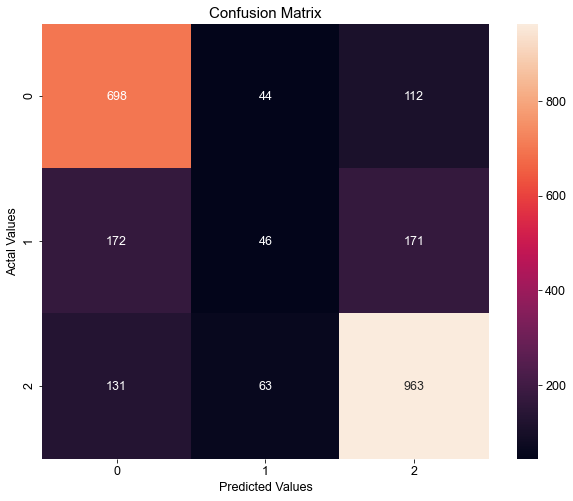

In [101]:
# Plot new confusion matrix / Heat Map from df
plt.figure( figsize=(10,8))
sns.heatmap(c3df_con_mat, annot=True, fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [102]:
print(classification_report(c3raw_testY, c3raw_onehot_y_pred));

              precision    recall  f1-score   support

           0       0.70      0.82      0.75       854
           1       0.30      0.12      0.17       389
           2       0.77      0.83      0.80      1157

    accuracy                           0.71      2400
   macro avg       0.59      0.59      0.57      2400
weighted avg       0.67      0.71      0.68      2400



Generally the model performs well with an accuracy of 74% much higher than the baseline of 33.3%. There is one exception which is class 1 - the neutral class - as seen from the error metrics and confusion matrix, performance in regards to this class is poor and brings down the overall results. This, however is hardly surprising. Firstly the neural class is conceptually much smaller as it was not made up of two classes like the other - negative, for example, being the synthesis of all types of negative and so on . Secondly the amount of training data on class 1 is far less than the other two classes. Thirdly, it is arguably a conceptually ambiguous class, text based truly neutral comments are rare and usually there is a slight inflection towards positive or negative. The model could thus be improved further by either removing class 1 transforming the problem into a binary one or by adding more training data to class 1.

# Markdown Word count
* 2312

# References
* [Amazon review dataset, Nagadia, 15/12/22](https://www.kaggle.com/datasets/meetnagadia/amazon-kindle-book-review-for-sentiment-analysis)
* Text Normalization functions, AE1 Natural Language Processing, Isaac Lambert, 15/12/22
* Phrase detection and Word2Vec, Word_vectors - week 6 Labs, Mahsa Abazari, 15/12/22
* [Word Cloud, Aman Kharwal, 16/12/22](https://thecleverprogrammer.com/2021/11/11/word-cloud-from-a-pandas-dataframe-in-python/#:~:text=A%20word%20cloud%20is%20a,based%20on%20natural%20language%20processing.)
* One hot encoding labels, Week 6 Labs, Mahsa Abazari, 18/12/22
* [Pre-trained word embeddings, Standford AI, 18/12/22](https://nlp.stanford.edu/projects/glove/)
* [Arun Pandian, 17/12/22, This notebook was a useful template in the following sections:](https://www.kaggle.com/code/arunrk7/nlpbeginner-text-classification-using-lstm)
    * Splitting the data 
    * Padding pre-trained word embeddings
    * Embedding matrix / layer 
    * Neural Network
* Neural Network explanation, Lectures weeks 6-10, Mahsa Abzari, 19/12/22
